# Using Pyro for Estimation

<div class="alert alert-info">

Note

Currently we are still experimenting with Pyro and support Pyro only in LGT and KTR models.

</div>

[Pyro](https://github.com/pyro-ppl/pyro)  is a flexible, scalable deep probabilistic programming library built on PyTorch.  **Pyro** was originally developed at Uber AI and is now actively maintained by community contributors, including a dedicated team at the Broad Institute. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

from orbit.constants.palette import OrbitPalette

In [2]:
print(orbit.__version__)

1.1.3dev


In [3]:
df = load_iclaims()

In [4]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## VI Fit and Predict

Although Pyro provides a variety of ways to optimize/sample posteriors.  Currently, we only support Stochastic Variational Inference (SVI). For details, please refer to this [doc](https://pyro.ai/examples/svi_part_i.html). 

To use SVI for LGT, specify estimator as `pyro-svi`.

In [5]:
lgt_vi = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    estimator='pyro-svi',
    num_steps=101,
    num_sample=300,
    # trigger message per 50 steps
    message=50,
    learning_rate=0.1,
)

In [6]:
%%time
lgt_vi.fit(df=train_df)

INFO:orbit:Using SVI (Pyro) with steps: 101, samples: 300, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:root:Guessed max_plate_nesting = 2
INFO:orbit:step    0 loss = 658.91, scale = 0.11635
INFO:orbit:step   50 loss = -432, scale = 0.48623
INFO:orbit:step  100 loss = -444.07, scale = 0.34976


CPU times: user 5.7 s, sys: 520 ms, total: 6.22 s
Wall time: 5.76 s


In [7]:
predicted_df = lgt_vi.predict(df=test_df)

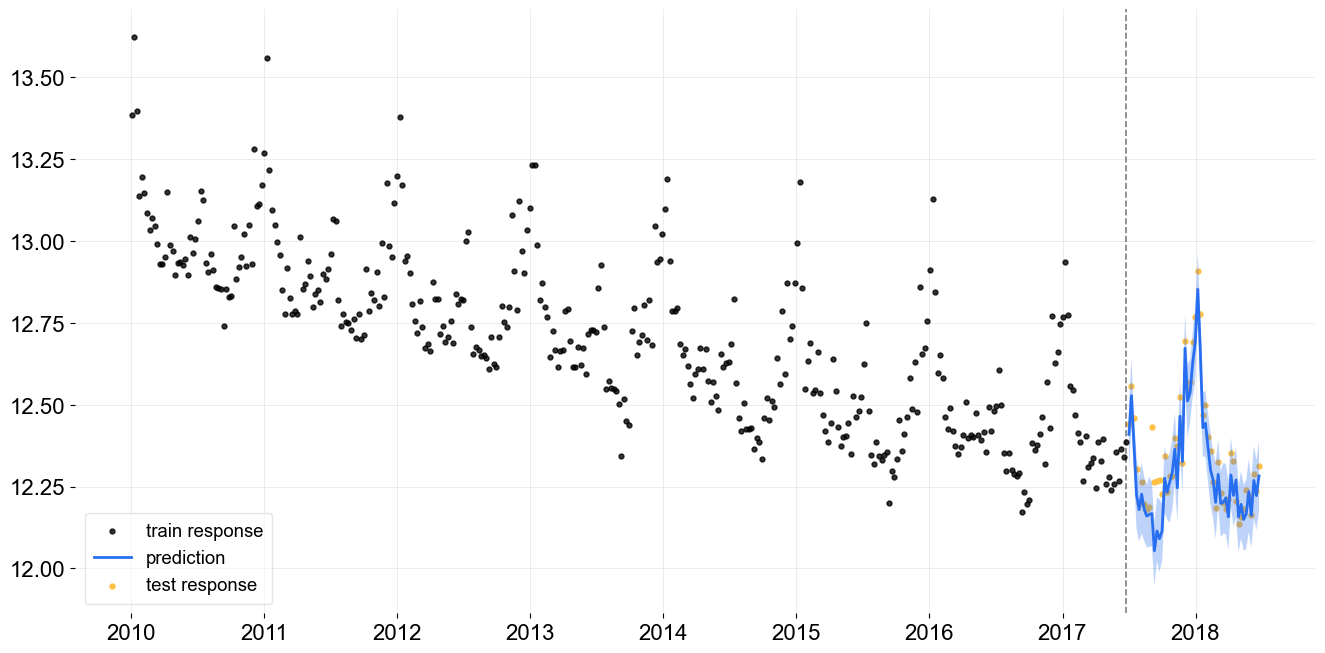

In [8]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, 
                    test_actual_df=test_df)

We can also extract the ELBO loss from the training metrics.

In [9]:
loss_elbo = lgt_vi.get_training_metrics()['loss_elbo']

Text(0.5, 1.0, 'ELBO Loss per Step')

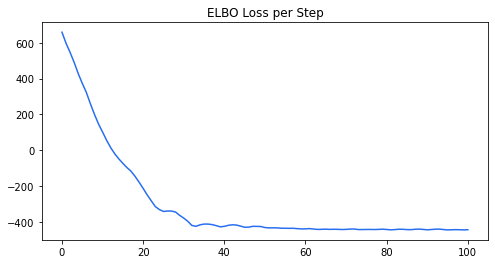

In [10]:
steps = np.arange(len(loss_elbo))
plt.subplots(1, 1, figsize=(8, 4))
plt.plot(steps, loss_elbo, color=OrbitPalette.BLUE.value)
plt.title('ELBO Loss per Step')